# PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle

In [1]:

import numpy as np   
import pandas as pd 

# импортируем библиотеки для визуализации
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 

import category_encoders as ce

# Библиотека для анализа настроения отзывов
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import datetime
# Для вычисления координат
from geopy.distance import geodesic as GD

# Для нормализации, стандартизации
from sklearn import preprocessing

# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

%matplotlib inline
matplotlib.style.use('ggplot')
# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/guljansamar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Прочтем данные , узнаем их размерность и посмотрим на них

df = pd.read_csv('hotels.csv')     # ('hotels.csv', encoding='cp1251') ввести, если ошибка при чтении-python не может прочитать , если вести в google.com cp1251)
df.head(5)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


Проверка и исследование данных.
Cначала разберемся с данными, проверив их структуру и определив пропущенные значения, выбросы и несоответствия, а также проверим повторяющиеся строки с помощью df.duplicated()

In [5]:
df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
386798    False
386799    False
386800    False
386801    False
386802    False
Length: 386803, dtype: bool

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

Из приведенных выше данных мы видим, что lat и lng имеют неодинаковое количество значений. Некоторые столбцы являются категориальными и имеют объекты типа данных, а некоторые имеют целочисленные значения и значения с плавающей запятой.

In [7]:
# Проверим категориальные и числовые столбцы.

# Categorical columns
cat_col = [col for col in df.columns if df[col].dtype == 'object']
print('Categorical columns :',cat_col)
# Numerical columns
num_col = [col for col in df.columns if df[col].dtype != 'object']
print('Numerical columns :',num_col)

Categorical columns : ['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review']
Numerical columns : ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'lat', 'lng']


In [8]:
#Проверим общее количество уникальных значений в категориальных столбцах.
df[cat_col].nunique()

hotel_address             1493
review_date                731
hotel_name                1492
reviewer_nationality       225
negative_review         248828
positive_review         311737
tags                     47135
days_since_review          731
dtype: int64

Машины не понимают текстовые данные. И нам придется либо отбросить, либо преобразовать значения категориальных столбцов в числовые типы. Теперь нам надо принять решение в контексте поставленной задачи.  

In [9]:
# Что касается tags, давайте сначала распечатаем 50 уникальных тегов
df['tags'].unique()[:50]

array(["[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",
       "[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",
       "[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",
       "[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']",
       "[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']",
       "[' Business trip ', ' Solo traveler ', ' Superior Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",
       "[' Leisure trip ', ' Couple ', ' Double Room Non Smoking ', ' Stayed 1 night ', ' Submitted from a mobile device ']",
       "[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 4 nights ']",
       "[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ']",
       "[' Leisure trip ', ' Couple ', 

In [10]:
# Узнаем сколько уникальных тегов представлено в наборе данных
# Делаем срез и разделяем теги

tags_list = df['tags'].apply(lambda x: x[3:-3].split(" ', ' "))
tags = tags_list.explode(ignore_index=True)
print(f'Количество уникальных тегов: {tags.nunique()}\n')

print(f'Самый частый тег: {tags.mode()[0]}\n')

# С помощью регулярного выражения находим строки с тегом "остановок на ночь"
reg = r'(S\w{5}\s\d+\sn\w{4,5})'


reg = r'(S\w{5}\s\d+\sn\w{4,5})'
night_tags = tags.str.extract(reg)
print(f'Самый частый тег с указанием на сколько ночей останавливаюся клиенты в отелях: {night_tags[0].value_counts().index[0]}')



Количество уникальных тегов: 2368

Самый частый тег: Leisure trip

Самый частый тег с указанием на сколько ночей останавливаюся клиенты в отелях: Stayed 1 night


In [11]:
# удалим нерелевантыне наблюдения в контексте поставленной перед нами задачи
df1 = df.drop(columns=['tags', 'days_since_review'])
df1.shape

(386803, 15)

In [12]:
#Обработка недостающих данных

round((df1.isnull().sum()/df1.shape[0])*100,2)

hotel_address                                 0.00
additional_number_of_scoring                  0.00
review_date                                   0.00
average_score                                 0.00
hotel_name                                    0.00
reviewer_nationality                          0.00
negative_review                               0.00
review_total_negative_word_counts             0.00
total_number_of_reviews                       0.00
positive_review                               0.00
review_total_positive_word_counts             0.00
total_number_of_reviews_reviewer_has_given    0.00
reviewer_score                                0.00
lat                                           0.63
lng                                           0.63
dtype: float64

In [14]:
# Как мы видим из приведенного выше результата, lat , lng  имеют 63% нулевых значений

df1['lat'] = df1['lat'].fillna(0)
df1['lng'] = df1['lng'].fillna(0)

# создаем новый дата фрейм df2 с заполненными значениями из df1
df2 = df1.copy()

# проверим еще раз в  df2
null_counts_df2 = df2.isnull().sum()
print(null_counts_df2)


hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
lat                                           0
lng                                           0
dtype: int64


Обработка выбросов
Выбросы — могут негативно повлиять на анализ и производительность модели. 
Чтобы проверить выбросы, мы обычно используем коробчатую диаграмму. Отдельные точки за пределами усов считаются потенциальными выбросами. Ящичковая диаграмма дает простой для понимания обзор диапазона данных и позволяет выявлять выбросы или асимметрию в распределении.


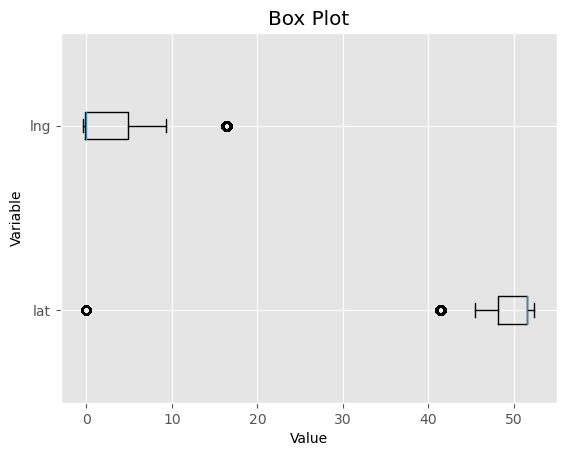

In [15]:
#Давайте построим ящичковую диаграмму для данных lng, lat

import matplotlib.pyplot as plt

# Extract lat and lng columns separately
lat = df2['lat']
lng = df2['lng']

# Create a boxplot
plt.boxplot([lat, lng], vert=False)
plt.ylabel('Variable')
plt.xlabel('Value')
plt.title('Box Plot')
plt.yticks([1, 2], ['lat', 'lng'])  # Customize y-axis ticks
plt.show()


In [17]:
#Как мы видим из приведенного выше графика «Коробка и усы», в нашем наборе данных lng, lat  есть выбросы.

# рассчитаем сводную статистику для 'lat'
lat_mean = df2['lat'].mean()
lat_std = df2['lat'].std()

# расчет верхних и нижних границ  для 'lat'
lat_lower_bound = lat_mean - lat_std * 2
lat_upper_bound = lat_mean + lat_std * 2

print('Summary Statistics for lat:')
print('Mean:', lat_mean)
print('Standard Deviation:', lat_std)
print('Lower Bound:', lat_lower_bound)
print('Upper Bound:', lat_upper_bound)

# рассчитаем сводную статистику для 'lng'
lng_mean = df2['lng'].mean()
lng_std = df2['lng'].std()

# расчет верхних и нижних границ  для 'lng'
lng_lower_bound = lng_mean - lng_std * 2
lng_upper_bound = lng_mean + lng_std * 2

print('\nSummary Statistics for lng:')
print('Mean:', lng_mean)
print('Standard Deviation:', lng_std)
print('Lower Bound:', lng_lower_bound)
print('Upper Bound:', lng_upper_bound)

# дропнем аутлаерами для  'lng'
df3 = df2[(df2['lng'] >= lng_lower_bound) & (df2['lng'] <= lng_upper_bound)]


Summary Statistics for lat:
Mean: 49.1306039775387
Standard Deviation: 5.226612872920783
Lower Bound: 38.67737823169713
Upper Bound: 59.58382972338026

Summary Statistics for lng:
Mean: 2.805533178659938
Standard Deviation: 4.570017795422488
Lower Bound: -6.334502412185038
Upper Bound: 11.945568769504913


In [18]:
#df3.info()

In [18]:
#посмотрим на столбцы чтоб не расстерялись
df3.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'lat',
       'lng'],
      dtype='object')

Преобразование данных.
Преобразование данных включает в себя преобразование данных из одной формы в другую, чтобы сделать их более подходящими для анализа. Для преобразования данных можно использовать такие методы, как нормализация, масштабирование или кодирование.

In [23]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def scale_numerical_columns(df):
    """
    Масштабируем числовые столбцы в DataFrame с помощью MinMaxScaler.

    Args:
    df (DataFrame): Input DataFrame , содержит числовые столбцы, подлежащие масштабированию
    Returns:
    DataFrame: DataFrame с масштабированными числовыми столбцами.
    """
    # Запускаем the MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # выделяем numerical columns
    num_col_ = df3.select_dtypes(include=['number']).columns

    # создаем a copy of the DataFrame
    x1 = df3.copy()

    # fir. для преобразования выбранных числовых столбцов
    x1[num_col_] = scaler.fit_transform(x1[num_col_])

    return x1



In [24]:
#Количество элементов в столбце
#Мы можем использовать функцию value_counts() из pandas,
#чтобы получить количество каждого элемента в наборе данных.

df3['hotel_address'].value_counts()


163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              3587
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     3206
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     3095
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    2688
7 Pepys Street City of London London EC3N 4AF United Kingdom                      2379
                                                                                  ... 
9 Rue de Constantinople 8th arr 75008 Paris France                                   9
Via Palmanova 153 20132 Milan Italy                                                  7
40 Rue Rene Boulanger 10th arr 75010 Paris France                                    7
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                              6
13 Rue Fran ois Ory 92120 Paris France                                               5
Name: hotel_address, Length: 1346, dtype: i

In [25]:
# Importing pandas
import pandas as pd

# Определение функции для extract the country from the hotel address
def get_country(address):
    return address.split(' ')[-1]

# Определение функции для извлечения  city from the hotel address
def get_city(address):
    return address.split(' ')[-2]

# применяем функции чтобы создать новый столбцы для country and city
df3.loc[:, 'country'] = df3['hotel_address'].apply(lambda x: get_country(x))
df3.loc[:, 'city'] = df3['hotel_address'].apply(lambda x: get_city(x))

# Displaying the DataFrame
df3.head()


/var/folders/nk/gz82c9nn2y5bc4f3wzr8bpjw0000gn/T/ipykernel_810/4153463853.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.loc[:, 'country'] = df3['hotel_address'].apply(lambda x: get_country(x))
/var/folders/nk/gz82c9nn2y5bc4f3wzr8bpjw0000gn/T/ipykernel_810/4153463853.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.loc[:, 'city'] = df3['hotel_address'].apply(lambda x: get_city(x))


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,country,city
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,51.507894,-0.143671,Kingdom,United
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,51.521009,-0.123097,Kingdom,United
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,48.845377,2.325643,France,Paris
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,48.888697,2.394540,France,Paris
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,52.385601,4.847060,Netherlands,Amsterdam


In [26]:
#df3['city'].value_counts()

In [27]:
df3['country'].value_counts()

Kingdom        196774
Spain           45132
France          44830
Netherlands     43006
Italy           27883
Austria          1990
Name: country, dtype: int64

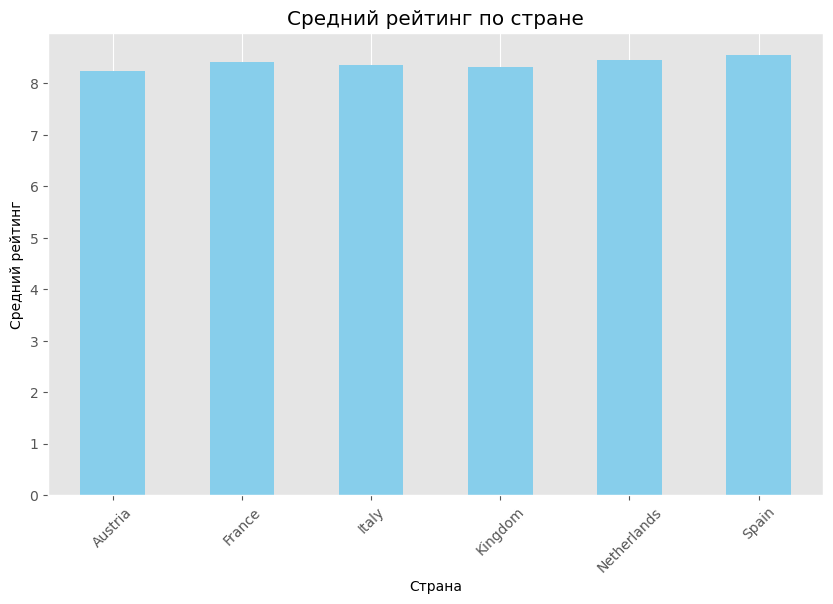

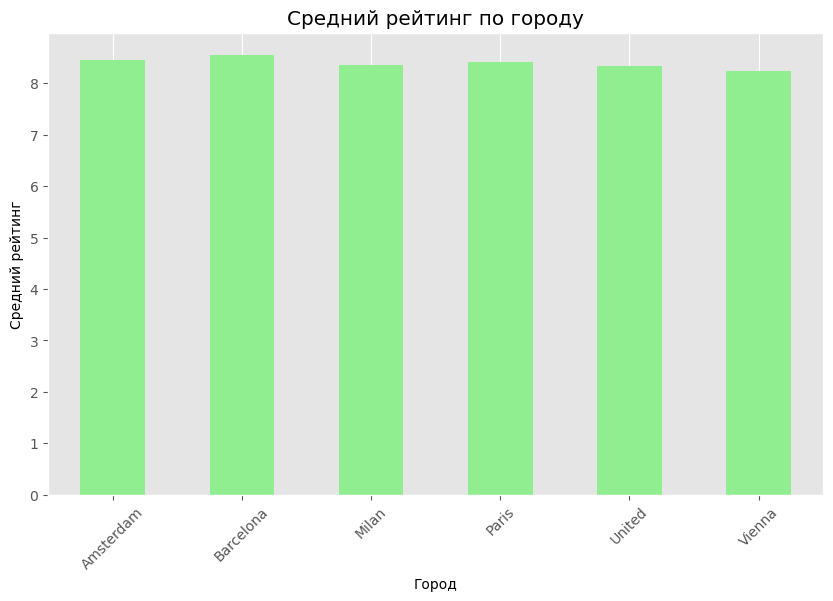

In [28]:
#Видно, что в данных присутствуют 6 стран и 6 городов в этих странах, скорее всего один из этих признаков можно удалить. 
#Чтобы в этом убедиться, построим столбчатые диаграммы зависимости оценки от страны и города нахождения отеля.

import matplotlib.pyplot as plt

# Группировка данных по стране и вычисление среднего значения оценки
mean_rating_country = df3.groupby('country')['reviewer_score'].mean()
mean_rating_city = df3.groupby('city')['reviewer_score'].mean()

# Построение графика для оценки по стране
plt.figure(figsize=(10, 6))
mean_rating_country.plot(kind='bar', color='skyblue')
plt.title('Средний рейтинг по стране')
plt.xlabel('Страна')
plt.ylabel('Средний рейтинг')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Построение графика для оценки по городу
plt.figure(figsize=(10, 6))
mean_rating_city.plot(kind='bar', color='lightgreen')
plt.title('Средний рейтинг по городу')
plt.xlabel('Город')
plt.ylabel('Средний рейтинг')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [29]:
#удалим город и адрес из датасета( по столбцам)
df3=df3.drop(['city', 'hotel_address'], axis=1)
df3

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,country
0,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,51.507894,-0.143671,Kingdom
1,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,51.521009,-0.123097,Kingdom
2,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,48.845377,2.325643,France
3,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,48.888697,2.394540,France
4,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,52.385601,4.847060,Netherlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386797,918,11/8/2015,8.4,Club Quarters Hotel St Paul s,Sweden,Our room was really cold and we had problem w...,25,4117,It is a nice and clean hotel with a good loca...,13,3,7.9,51.513930,-0.101126,Kingdom
386798,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,8.8,51.494028,-0.191050,Kingdom
386800,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,8.3,51.520795,-0.131084,Kingdom
386801,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,9.2,51.515125,-0.160066,Kingdom


In [30]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359615 entries, 0 to 386802
Data columns (total 15 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                359615 non-null  int64  
 1   review_date                                 359615 non-null  object 
 2   average_score                               359615 non-null  float64
 3   hotel_name                                  359615 non-null  object 
 4   reviewer_nationality                        359615 non-null  object 
 5   negative_review                             359615 non-null  object 
 6   review_total_negative_word_counts           359615 non-null  int64  
 7   total_number_of_reviews                     359615 non-null  int64  
 8   positive_review                             359615 non-null  object 
 9   review_total_positive_word_counts           359615 non-null  int64  
 

In [31]:
import numpy as np

# конвертируем 'country' column to a NumPy array
arr_country = np.array(df3['country'])

# При необходимости изменим форму массива, укажем желаемую форму
arr_country_reshaped = arr_country.reshape(-1, 1)  

# Выведим измененный массив
arr_country_reshaped



array([['Kingdom'],
       ['Kingdom'],
       ['France'],
       ...,
       ['Kingdom'],
       ['Kingdom'],
       ['Kingdom']], dtype=object)

In [32]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# Предполагая, что df3 — это DataFrame, а df3['country'] — столбец, который надо закодировать.
# Давайте создадим образец DataFrame для демонстрации
# df3 = pd.DataFrame({'country': ['США', 'Великобритания', 'Франция', 'Германия', 'США']})

# Инициализируем OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# исполнение ordinal encoding
df3['country_encoded'] = ordinal_encoder.fit_transform(df3[['country']])

# Отобразим полученный DataFrame
df3



,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,country,country_encoded
0,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,51.507894,-0.143671,Kingdom,3.0
1,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,51.521009,-0.123097,Kingdom,3.0
2,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,48.845377,2.325643,France,1.0
3,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,48.888697,2.394540,France,1.0
4,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,52.385601,4.847060,Netherlands,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386797,918,11/8/2015,8.4,Club Quarters Hotel St Paul s,Sweden,Our room was really cold and we had problem w...,25,4117,It is a nice and clean hotel with a good loca...,13,3,7.9,51.513930,-0.101126,Kingdom,3.0
386798,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,8.8,51.494028,-0.191050,Kingdom,3.0
386800,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,8.3,51.520795,-0.131084,Kingdom,3.0
386801,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,9.2,51.515125,-0.160066,Kingdom,3.0


In [33]:
df3['hotel_name'].value_counts()

Britannia International Hotel Canary Wharf           3587
Strand Palace Hotel                                  3206
Park Plaza Westminster Bridge London                 3095
Copthorne Tara Hotel London Kensington               2688
DoubleTree by Hilton Hotel London Tower of London    2379
                                                     ... 
Ibis Styles Paris Gare Saint Lazare                     9
Ibis Styles Milano Palmanova                            7
Renaissance Paris Republique Hotel Spa                  7
Hotel Wagner                                            6
Mercure Paris Porte d Orleans                           5
Name: hotel_name, Length: 1346, dtype: int64

In [81]:
#Этот кусочек из кода, где пыталась группировать отели по отзывам.
#Но потом оставила затею.


# считаем число отзывов для группы отелей 
#hotel_review_counts = df3.groupby('hotel_name').size().reset_index(name='review_count')

# Filter the dataset to include only hotels with a certain number of reviews (e.g., at least 5 reviews)
#min_reviews = 5
#hotels_with_min_reviews = hotel_review_counts[hotel_review_counts['review_count'] >= min_reviews]

# Filter the original DataFrame to include only the hotels with at least the minimum number of reviews
#df_filtered = df3[df3['hotel_name'].isin(hotels_with_min_reviews['hotel_name'])]

#df_filtered



In [34]:
# cмотрим на число критиков  (по странам присхождения) 

df3['reviewer_nationality'].value_counts()         

 United Kingdom               178790
 United States of America      24364
 Australia                     15032
 Ireland                       10654
 United Arab Emirates           6787
                               ...  
 Antarctica                        1
 Cook Islands                      1
 Guinea                            1
 Comoros                           1
 Grenada                           1
Name: reviewer_nationality, Length: 223, dtype: int64

In [35]:
# # Отсортируем столбец reviewer_nationality по количеству значений в порядке убывания и нормализуем количество.

reviewer_nationality_sorted = df3['reviewer_nationality'].value_counts(normalize=True).sort_values(ascending=False)

# Получим 10 самых частых национальностей рецензентов
rank = reviewer_nationality_sorted.nlargest(10).index 

# Заменим все значения в столбце reviewer_nationality, которые не входят в первую десятку -  на «other».
df3['reviewer_nationality'] = df3['reviewer_nationality'].apply(lambda x: x if x in rank else 'Other')

# Подсчитаем количество вхождений каждого значения в обновленном столбце 
df3['reviewer_nationality'].value_counts()



 United Kingdom               178790
Other                          94976
 United States of America      24364
 Australia                     15032
 Ireland                       10654
 United Arab Emirates           6787
 Saudi Arabia                   6302
 Netherlands                    6055
 Switzerland                    5944
 Canada                         5462
 Germany                        5249
Name: reviewer_nationality, dtype: int64

In [36]:
import pandas as pd
import category_encoders as ce

# если reviewer_nationality has missing values, заполним их с mode
if df3['reviewer_nationality'].isnull().any():
    most_frequent_nationality = df3['reviewer_nationality'].mode()[0]
    df3['reviewer_nationality'].fillna(most_frequent_nationality, inplace=True)

# создадим экземпляр of the OrdinalEncoder class
ord_enc = ce.OrdinalEncoder()

# закодируем  the 'reviewer_nationality' column with Ordinal Encoding
df3_ord_encode = ord_enc.fit_transform(df3[['reviewer_nationality']])
# объединим  the original DataFrame with the encoded DataFrame
df3 = pd.concat([df3, df3_ord_encode ], axis=1)
df3

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,country,country_encoded,reviewer_nationality
0,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,51.507894,-0.143671,Kingdom,3.0,1
1,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,51.521009,-0.123097,Kingdom,3.0,1
2,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,Other,No kettle in room,6,406,No Positive,0,14,7.5,48.845377,2.325643,France,1.0,2
3,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,48.888697,2.394540,France,1.0,1
4,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Other,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,52.385601,4.847060,Netherlands,4.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386797,918,11/8/2015,8.4,Club Quarters Hotel St Paul s,Other,Our room was really cold and we had problem w...,25,4117,It is a nice and clean hotel with a good loca...,13,3,7.9,51.513930,-0.101126,Kingdom,3.0,2
386798,107,4/19/2017,9.0,Hotel Moonlight,Other,No Negative,0,617,Tr s proche du metro Earl s court,10,10,8.8,51.494028,-0.191050,Kingdom,3.0,2
386800,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,8.3,51.520795,-0.131084,Kingdom,3.0,6
386801,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,9.2,51.515125,-0.160066,Kingdom,3.0,4


In [81]:
#df3.info()

In [37]:
df3['negative_review'].value_counts()

No Negative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   88246
 Nothing                                                                                                                                                            

In [38]:
df3['positive_review'].value_counts()

No Positive                                                                                                                                                           25094
 Location                                                                                                                                                              6476
 Everything                                                                                                                                                            1582
 location                                                                                                                                                              1177
 Nothing                                                                                                                                                                888
                                                                                                                                            

In [39]:
# NLP- используем методы NLP, для обработки естественного языка
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

rev1 = "The hotel was very good, I love it!"
rev2 = "It was just horrible, the worst ever."

print(f"review 1:\n{rev1}\nScore: {sent_analyzer.polarity_scores(rev1)}")

print(f"\nreview 2:\n{rev2}\nScore: {sent_analyzer.polarity_scores(rev2)}")



review 1:
The hotel was very good, I love it!
Score: {'neg': 0.0, 'neu': 0.386, 'pos': 0.614, 'compound': 0.8386}

review 2:
It was just horrible, the worst ever.
Score: {'neg': 0.603, 'neu': 0.397, 'pos': 0.0, 'compound': -0.8225}


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/guljansamar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Отзывы были оценены с помощью анализа настроений, в результате чего был составлен словарь оценок для каждой категории настроений: отрицательный (neg), нейтральный (neu), положительный (pos) и общий составной балл (commun).

In [40]:
import pandas as pd

# Example data
data = {
    'review': [
        "The hotel was very good, I love it!",
        "It was just horrible, the worst ever."
    ],
    'neg': [0.0, 0.603],
    'neu': [0.386, 0.397],
    'pos': [0.614, 0.0],
    'compound': [0.8386, -0.8225]
}

# Create a DataFrame
review_df = pd.DataFrame(data)

# Concatenate review_df with df3 along columns
df3 = pd.concat([df3, review_df], axis=1)

# Display the updated DataFrame
print(df3)


        additional_number_of_scoring review_date  average_score  \
0                                581   2/19/2016            8.4   
1                                299   1/12/2017            8.3   
2                                 32  10/18/2016            8.9   
3                                 34   9/22/2015            7.5   
4                                914    3/5/2016            8.5   
...                              ...         ...            ...   
386797                           918   11/8/2015            8.4   
386798                           107   4/19/2017            9.0   
386800                           457    2/7/2016            6.8   
386801                           365   5/21/2017            8.1   
386802                           222    8/5/2016            9.0   

                                       hotel_name    reviewer_nationality  \
0                              The May Fair Hotel         United Kingdom    
1                 Mercure London Bloomsbu

In [41]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359615 entries, 0 to 386802
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                359615 non-null  int64  
 1   review_date                                 359615 non-null  object 
 2   average_score                               359615 non-null  float64
 3   hotel_name                                  359615 non-null  object 
 4   reviewer_nationality                        359615 non-null  object 
 5   negative_review                             359615 non-null  object 
 6   review_total_negative_word_counts           359615 non-null  int64  
 7   total_number_of_reviews                     359615 non-null  int64  
 8   positive_review                             359615 non-null  object 
 9   review_total_positive_word_counts           359615 non-null  int64  
 

In [42]:
# Заменим значения NaN соответствующими значениями
df3.fillna({'review': '', 'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}, inplace=True)

# Доступ к значениям NaN
# можно получить доступ к значениям NaN, используя логическое индексирование
nan_values = df3[df3['review'].isna()]

# Отобразим значений NaN
print(nan_values)


Empty DataFrame
Columns: [additional_number_of_scoring, review_date, average_score, hotel_name, reviewer_nationality, negative_review, review_total_negative_word_counts, total_number_of_reviews, positive_review, review_total_positive_word_counts, total_number_of_reviews_reviewer_has_given, reviewer_score, lat, lng, country, country_encoded, reviewer_nationality, review, neg, neu, pos, compound]
Index: []

[0 rows x 22 columns]


In [43]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359615 entries, 0 to 386802
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                359615 non-null  int64  
 1   review_date                                 359615 non-null  object 
 2   average_score                               359615 non-null  float64
 3   hotel_name                                  359615 non-null  object 
 4   reviewer_nationality                        359615 non-null  object 
 5   negative_review                             359615 non-null  object 
 6   review_total_negative_word_counts           359615 non-null  int64  
 7   total_number_of_reviews                     359615 non-null  int64  
 8   positive_review                             359615 non-null  object 
 9   review_total_positive_word_counts           359615 non-null  int64  
 

In [44]:
df3.head()

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,lat,lng,country,country_encoded,reviewer_nationality,review,neg,neu,pos,compound
0,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,...,51.507894,-0.143671,Kingdom,3.0,1,"The hotel was very good, I love it!",0.000,0.386,0.614,0.8386
1,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,...,51.521009,-0.123097,Kingdom,3.0,1,"It was just horrible, the worst ever.",0.603,0.397,0.000,-0.8225
2,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,Other,No kettle in room,6,406,No Positive,0,...,48.845377,2.325643,France,1.0,2,,0.000,0.000,0.000,0.0000
3,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,...,48.888697,2.394540,France,1.0,1,,0.000,0.000,0.000,0.0000
4,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Other,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,...,52.385601,4.847060,Netherlands,4.0,2,,0.000,0.000,0.000,0.0000


In [45]:
# преобразование столбца 'review_date'в формат datetime
df3.loc[:, 'review_date'] = pd.to_datetime(df['review_date'], errors='coerce')

# нахождение самого свежего и самого первого отзыва
latest_review_date = df3['review_date'].max()
earliest_review_date = df3['review_date'].min()

print(f"Самый свежий отзыв был оставлен: {latest_review_date.strftime('%Y-%m-%d')}")
print(f"Самый первый отзыв был оставлен: {earliest_review_date.strftime('%Y-%m-%d')}") 

Самый свежий отзыв был оставлен: 2017-08-03
Самый первый отзыв был оставлен: 2015-08-04


/var/folders/nk/gz82c9nn2y5bc4f3wzr8bpjw0000gn/T/ipykernel_810/3520581465.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df3.loc[:, 'review_date'] = pd.to_datetime(df['review_date'], errors='coerce')


In [46]:
df3.shape

(359615, 22)

In [47]:
# удалим только те признаки, из которых извлекли нужные нам данные
df3 = df3.drop(['hotel_name','reviewer_nationality', 'negative_review', 'positive_review', 'country', 'review'], axis=1)

In [42]:
#df3.info()

/var/folders/nk/gz82c9nn2y5bc4f3wzr8bpjw0000gn/T/ipykernel_810/4280146376.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df3.corr(), annot=True, linewidth=5)


<Axes: >

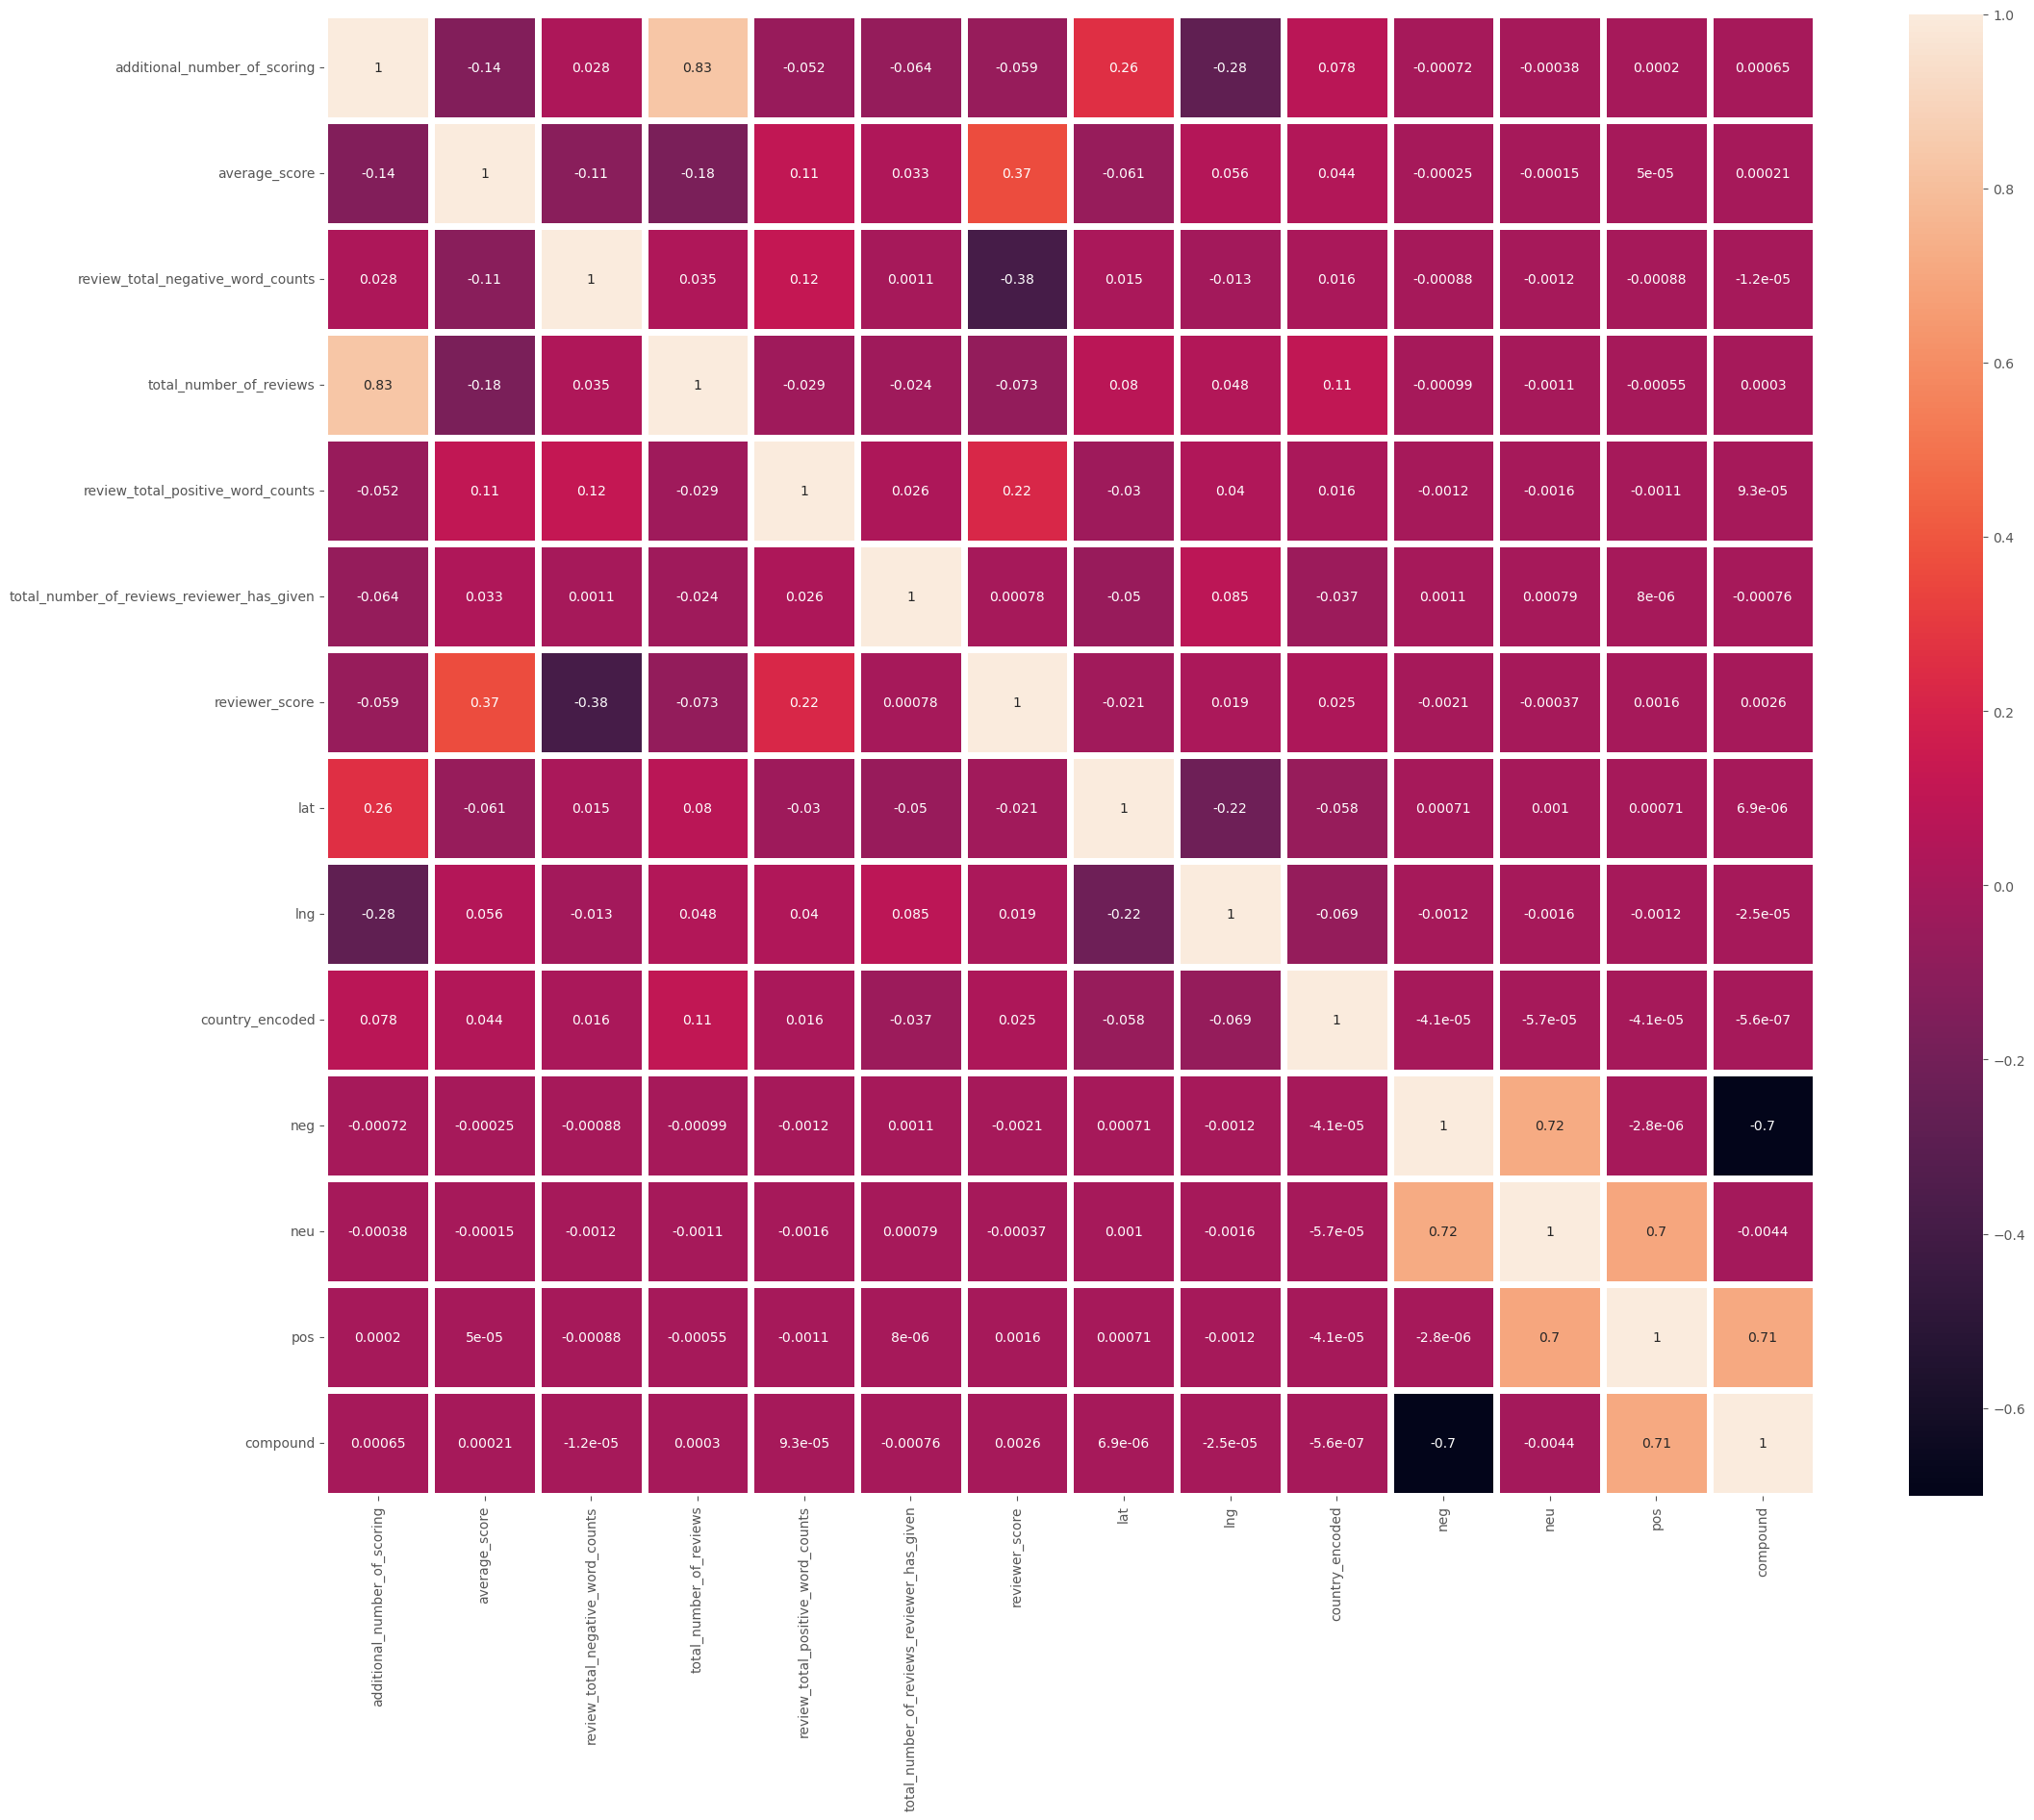

In [48]:
# проверим на мультиколлинеарность
fig = plt.figure(figsize = (25, 20))
sns.heatmap(df3.corr(), annot=True, linewidth=5)

In [49]:
# удалим признаки с коэф.коррел.>0.70

df3 = df3.drop(['total_number_of_reviews'], axis=1)

/var/folders/nk/gz82c9nn2y5bc4f3wzr8bpjw0000gn/T/ipykernel_2279/4280146376.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df3.corr(), annot=True, linewidth=5)


<Axes: >

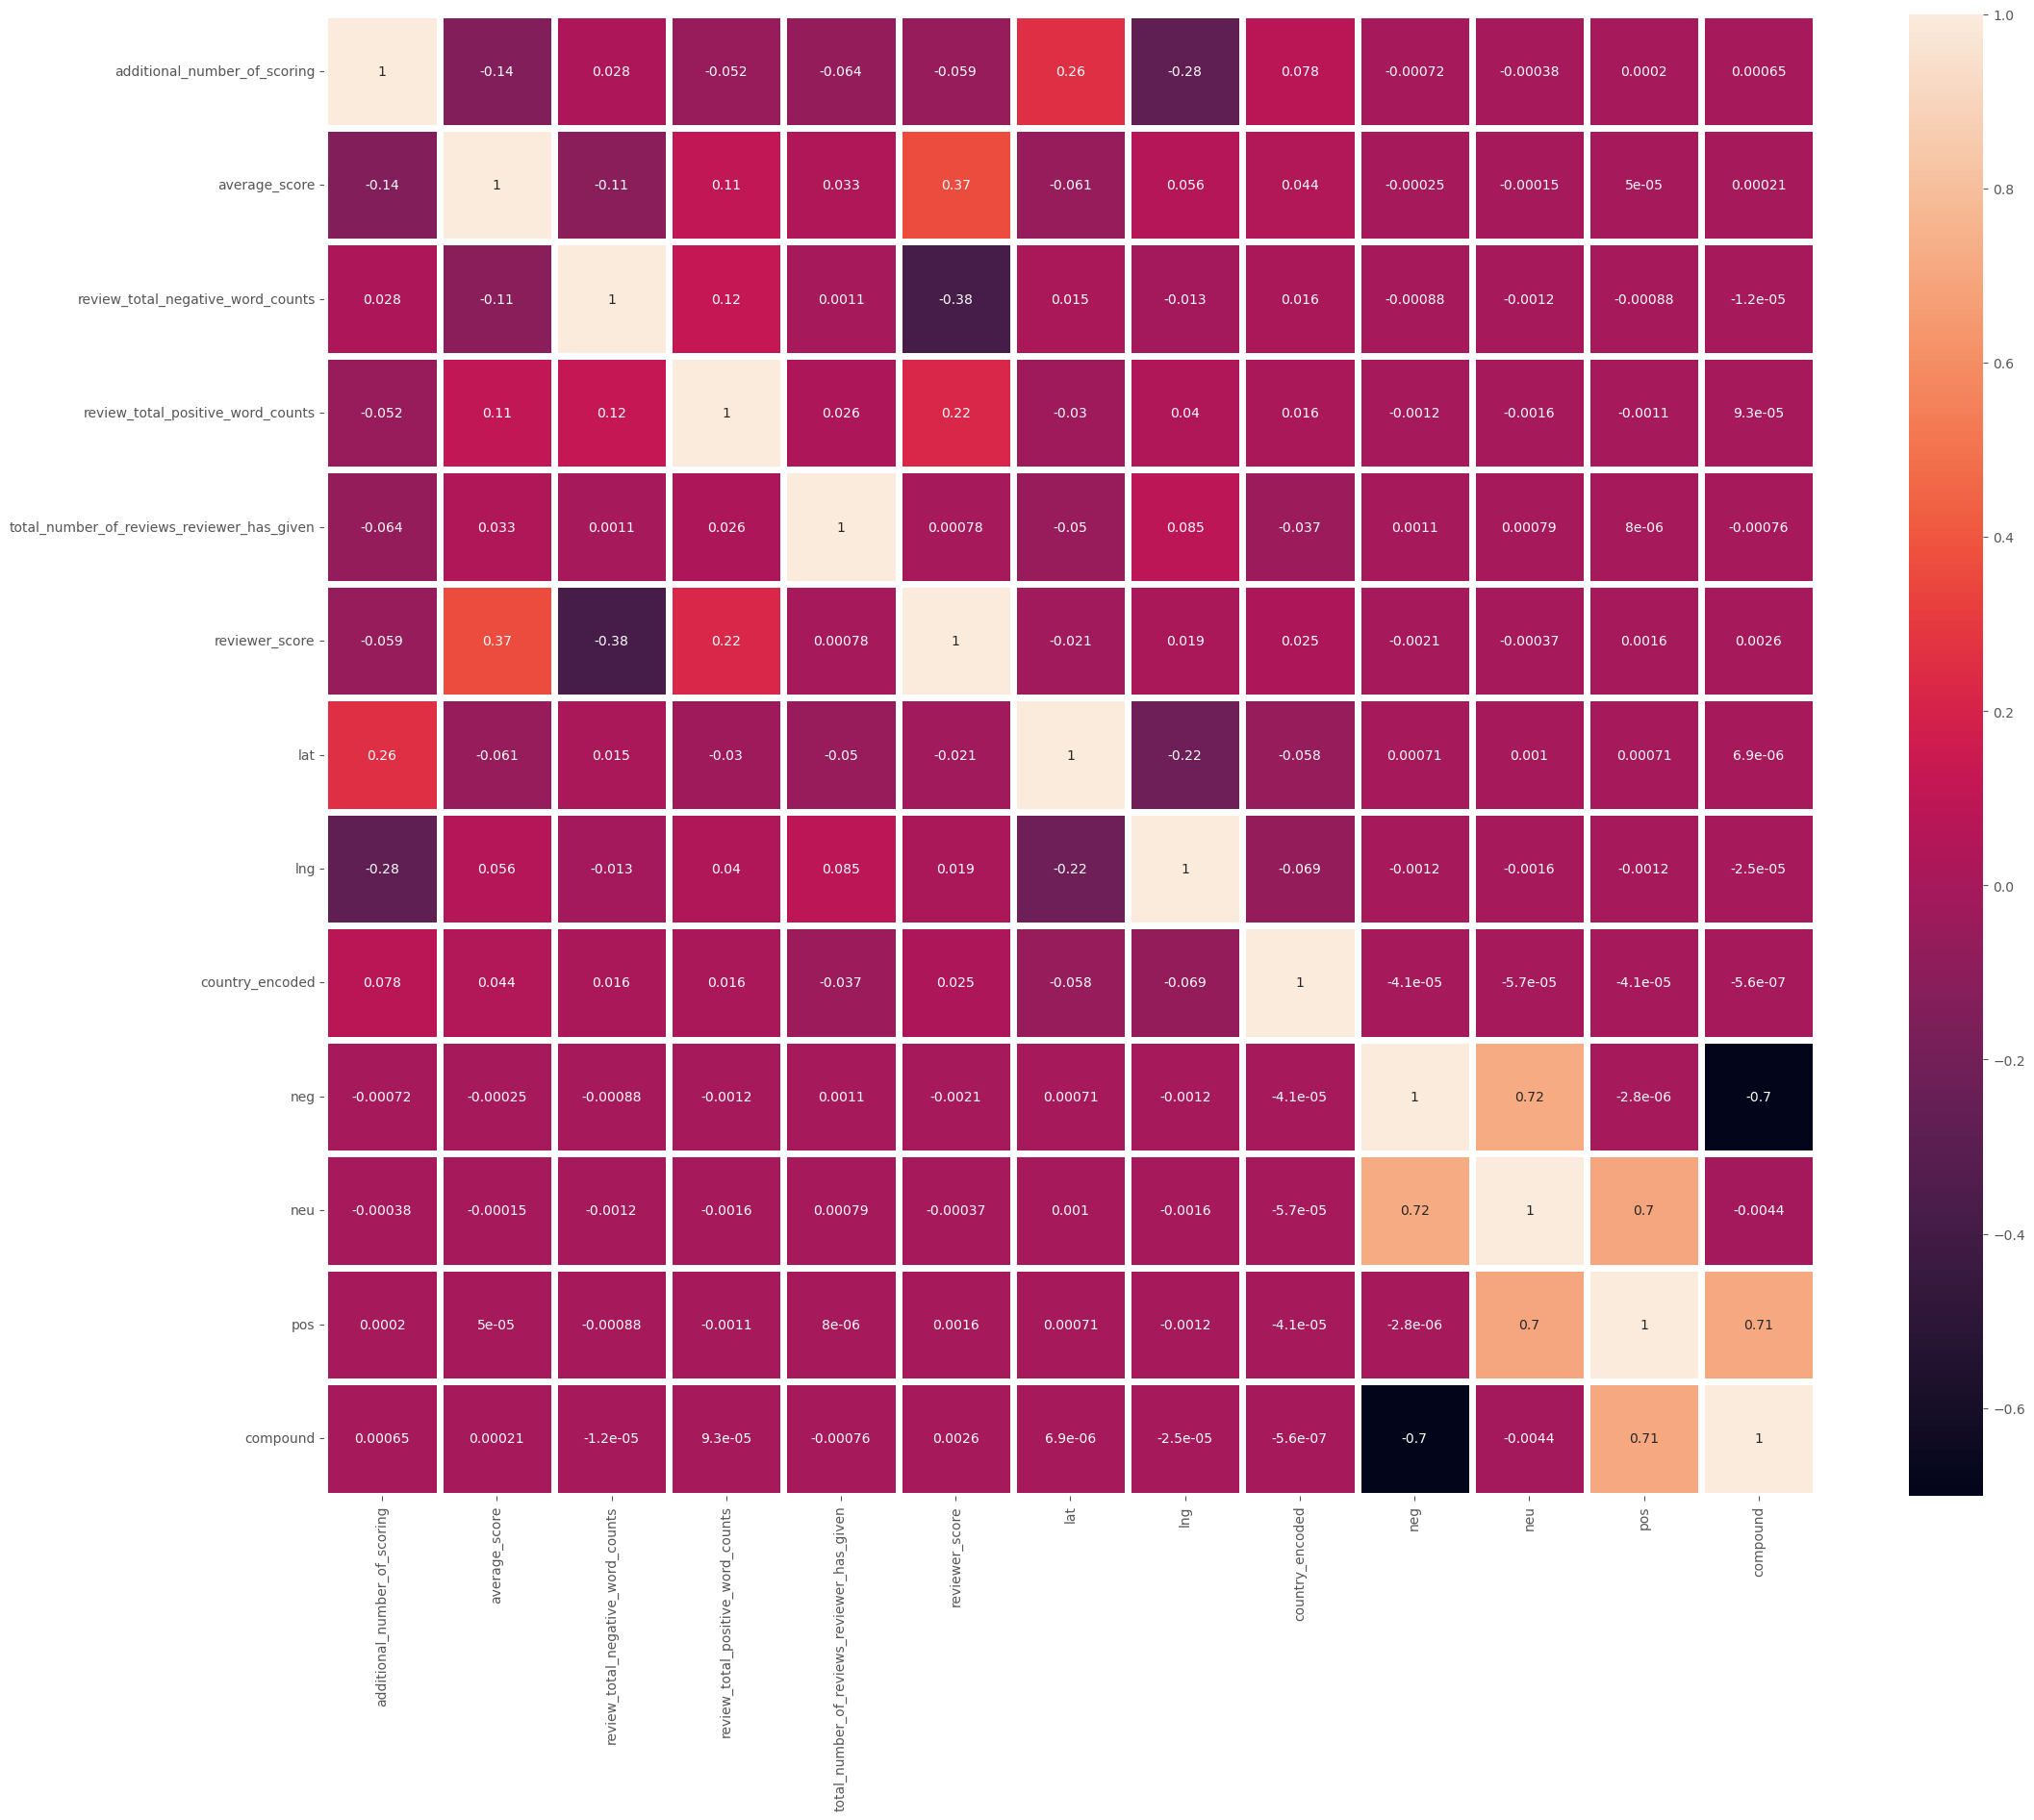

In [45]:
# проверим на мультиколлинеарность
fig = plt.figure(figsize = (25, 20))
sns.heatmap(df3.corr(), annot=True, linewidth=5)

In [50]:
#df3.columns

In [51]:
#df3.info()

In [2]:
#import pandas as pd

#df_numeric = df3.select_dtypes(include=['number'])

#df_categorical = df3.select_dtypes(include=['object'])

#num_cols = df_numeric.columns.tolist()
#cat_cols = df_categorical.columns.tolist()

#print(num_cols)
#print(cat_cols)


In [52]:
#Для прогнозирования машинного обучения: во-первых, мы разделяем независимые и целевые функции.

X = df3.drop(['reviewer_score'], axis=1)
y = df3['reviewer_score']

In [53]:
#Для начала разделим признаки по типу, перечислим их:

num_cols = ['additional_number_of_scoring', 'review_total_negative_word_counts',
            'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
            'neg', 'neu', 'pos', 'compound']

cat_cols = ['average_score', 'country_encoded', 'lng', 'lat']

Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.

<Axes: >

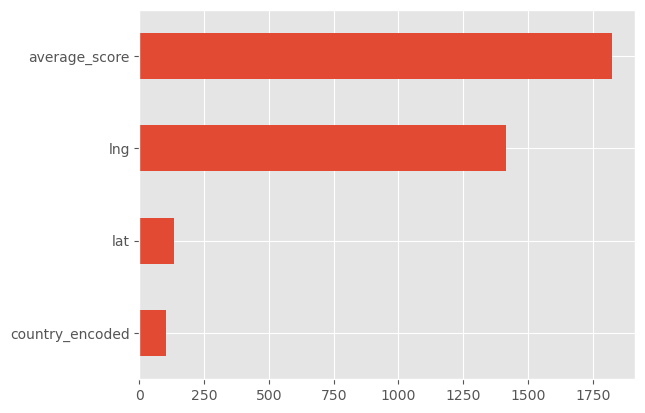

In [57]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import chi2

# Assuming X is your feature matrix and y is your target variable
# Identify numerical columns (excluding timestamp columns)
num_cols = X.select_dtypes(include=np.number).columns

# Replace negative values with zero for numerical columns
X[num_cols] = X[num_cols].apply(lambda x: np.maximum(x, 0))

# Compute chi-square statistics
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')



<Axes: >

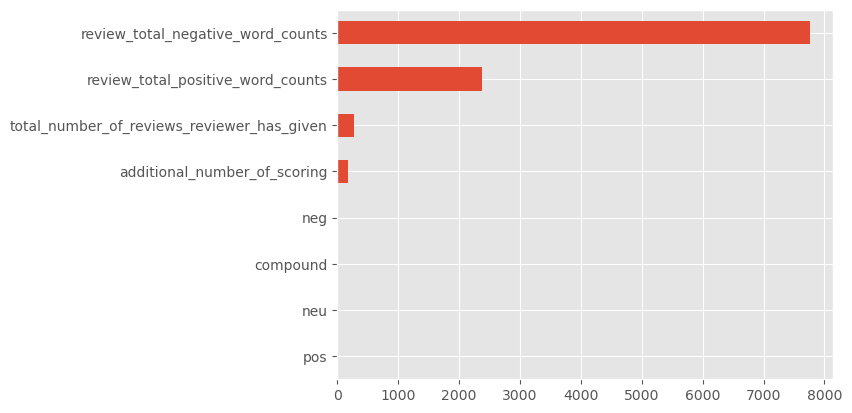

In [55]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Сначала мы конвертируем столбец даты и времени («review_date») в числовые функции («год», «месяц», «день») с помощью функций даты и времени pandas.
Затем мы удаляем исходный столбец даты и времени из DataFrame.
Затем мы разделяем DataFrame на функции (X) и целевую переменную (y).
Мы разделяем данные на обучающий и тестовый наборы с помощью train_test_split.
Мы стандартизируем числовые функции с помощью StandardScaler.
Наконец, мы инициализируем и подгоняем модель RandomForestRegressor, используя предварительно обработанные данные.

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load your DataFrame (df3) containing datetime and numerical features
# Assuming datetime column is 'review_date' and target column is 'reviewer_score'
# Replace these with your actual column names

# Convert datetime to numerical features (e.g., year, month, day)
df3['year'] = df3['review_date'].dt.year
df3['month'] = df3['review_date'].dt.month
df3['day'] = df3['review_date'].dt.day

# Drop the original datetime column
df3.drop(columns=['review_date'], inplace=True)

# Split the data into features (X) and target (y)
X = df3.drop(columns=['reviewer_score'])
y = df3['reviewer_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the RandomForestRegressor model
regr = RandomForestRegressor(n_estimators=100)
regr.fit(X_train_scaled, y_train)

# Evaluate the model
# (You can add evaluation metrics here)
train_score = regr.score(X_train_scaled, y_train)
test_score = regr.score(X_test_scaled, y_test)
print(f"Train score: {train_score}")
print(f"Test score: {test_score}")


Train score: 0.9159533063952793
Test score: 0.4011838788226926


In [86]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13937451665500047


Оценка Train score:
Это говорит нам о том, насколько хорошо наша модель обучилась на обучающих данных.  оценка Train score(близка к 100%), это означает, что наша модель очень хорошо соответствует данным обучения. Он может точно предсказать результаты на основе данных, на которых он обучался. Но надо смотреть чтоб и не переобучилась, т.к.оценка теста, значительно ниже, чем оценка обучения

Оценка Test score:
Это говорит нам о том, насколько хорошо наша модель работает с новыми, ранее неизвестными данными.

Хотя высокие результаты обучения и тестов являются хорошими показателями, это еще не все.
Крайне важно использовать другие методы и показатели оценки для тщательной оценки эффективности нашей модели.
Такие методы, как перекрестная проверка.
По сути, хотя высокие баллы являются хорошим знаком, важно копнуть глубже, чтобы убедиться, что наша модель надежна и может делать точные прогнозы в реальных сценариях.